### 初始化

In [27]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

### 添加 chatbot 节点

In [28]:
import os
from langchain_openai import AzureChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

llm = AzureChatOpenAI(
    azure_endpoint=os.environ["L_OPENAI_API_BASE"],
    azure_deployment=os.environ["L_OPENAI_API_DEPLOYMENT"],
    openai_api_version=os.environ["L_OPENAI_API_VERSION"],
    openai_api_key=os.environ["L_OPENAI_API_KEY"],
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
graph_builder.add_node("chatbot", chatbot)

### 添加工具集节点

In [29]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

### 绘制路径

In [30]:
from langgraph.prebuilt import tools_condition

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")

### 编译 Graph

In [31]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

### 运行

In [35]:
config = {"configurable": {"thread_id": "1"}}
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}, config, stream_mode="values"):
        event["messages"][-1].pretty_print()
    # for event in graph.stream({"messages": ("user", user_input)}, config):
    #     for value in event.values():
    #         if isinstance(value["messages"][-1], BaseMessage):
    #             print("Assistant:", value["messages"][-1].content)


================================ Human Message =================================

你好
================================== Ai Message ==================================

你好！有什么我可以帮助你的吗？
================================ Human Message =================================

我叫小红
================================== Ai Message ==================================

很高兴认识你，小红！有什么我可以帮助你的吗？
================================ Human Message =================================

你会唱歌吗
================================== Ai Message ==================================

作为一个文本助手，我无法直接唱歌。但是我可以提供歌词或者歌曲推荐给你。如果你有任何特定的歌曲或者歌手，可以告诉我，我会尽力帮助你。
================================ Human Message =================================

你还记得我叫什么吗？
================================== Ai Message ==================================

是的，你刚刚告诉我你叫小红。有什么我可以帮助你的吗，小红？
Goodbye!


### 打印 Graph

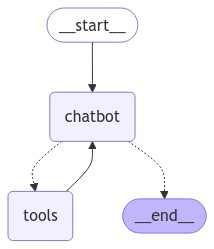

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 读取 state

In [36]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='你好', id='6dd2b2b9-b7d0-4a71-b2ea-60faa9b02452'), AIMessage(content='你好！有什么我可以帮助你的吗？', response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 83, 'total_tokens': 102}, 'model_name': 'gpt-35-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-1818e92c-d219-47b6-b800-ee0ba56918cd-0', usage_metadata={'input_tokens': 83, 'output_tokens': 19, 'total_tokens': 102}), HumanMessage(content='你好', id='416275e5-0342-4fc2-9d89-4a8ee40cd76c'), AIMessage(content='你好！有什么我可以帮助你的吗？', response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 111, 'total_tokens': 130}, 'model_name': 'gpt-35-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-da06a68f-9382-439a-a4f8-de8dea9a3e0d-0', usage_metadata={'input_tokens': 111, 'output_tokens': 19, 'total_tokens': 130}), HumanMessage(conten